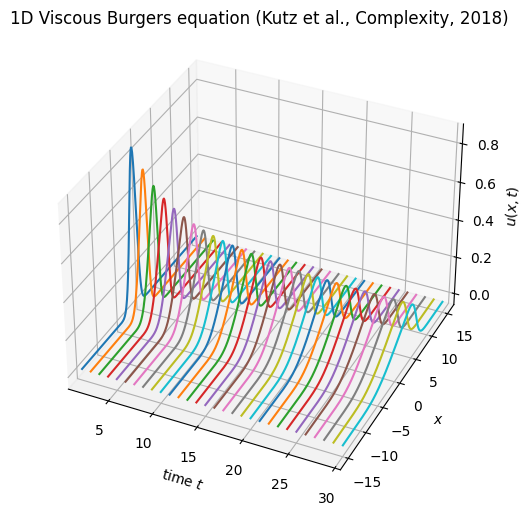

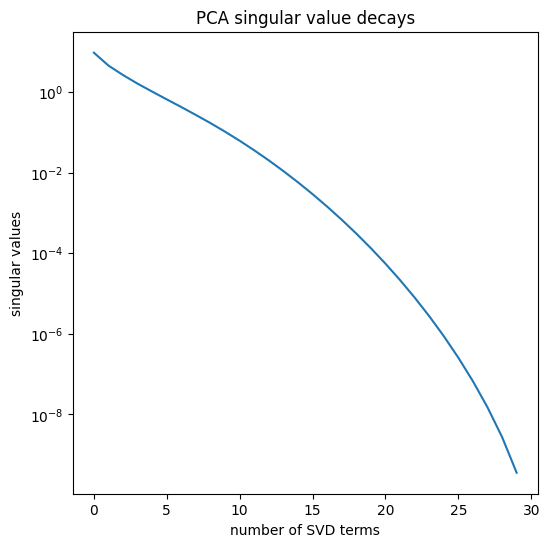

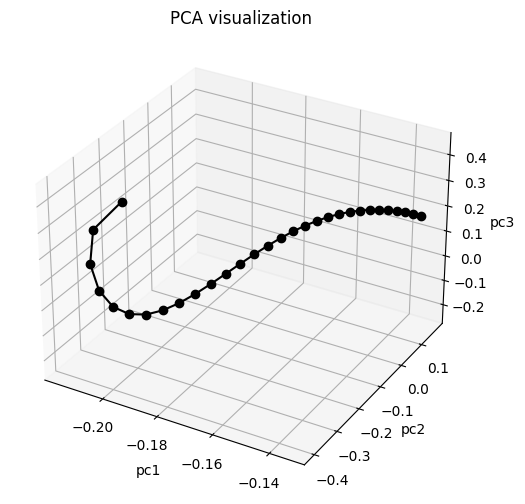

data shape =  (30, 256)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk
from pykoopman.common import vbe

n = 256
x = np.linspace(-15, 15, n, endpoint=False)
u0 = np.exp(-(x+2)**2)
# u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 3000
n_snapshot = 30
dt = 30. / n_int
n_sample = n_int // n_snapshot

model_vbe = vbe(n, x, dt=dt, L=30)
X, t = model_vbe.simulate(u0, n_int, n_sample)
delta_t = t[1]-t[0]

model_vbe.visualize_data(x, t, X)
model_vbe.visualize_state_space(X)

print("data shape = ",X.shape)

In [6]:
from pydmd import DMD

observables_pol = [lambda x,y: x*y ** 2, lambda x: 0 * x, lambda x, y: x * y]
observable_names = [
    lambda s: f"{s}^2",
    lambda s: str(0),
    lambda s, t: f"{s} {t}",
]

EDMD = pk.regression.EDMD()

obs = pk.observables.CustomObservables(observables_pol)
obsv = pk.observables.Polynomial(degree=2)

dmd = DMD(svd_rank=5)
model = pk.Koopman(regressor=EDMD, observables=obs)
model.fit(X, dt=delta_t)

Koopman(observables=CustomObservables(observable_names=[<function identity_name at 0x12c80e680>,
                                                        <function CustomObservables.fit.<locals>.<lambda>.<locals>.<lambda> at 0x302e03520>,
                                                        <function CustomObservables.fit.<locals>.<lambda>.<locals>.<lambda> at 0x302e03490>,
                                                        <function CustomObservables.fit.<locals>.<lambda>.<locals>.<lambda> at 0x302e02ef0>,
                                                        <function CustomObservables.fit.<locals>.<lambda>.<locals>.<lambda> at 0x302e03010>],
                                      observables=[<function identity at 0x12c80da20>,
                                                   <function <lambda> at 0x302e03400>,
                                                   <function <lambda> at 0x302e03250>,
                                                   <function <lambda> at 0x302e03370>]),
        regressor=EDMD())

Text(0, 0.5, '$Im(\\lambda)$')

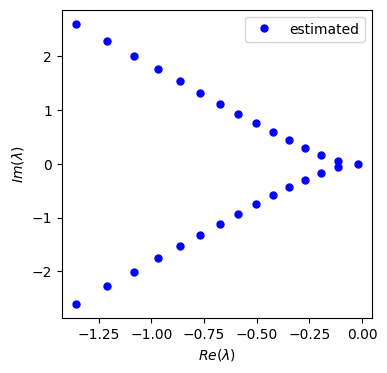

In [7]:
K = model.A

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


# ax.set_xlim([-0.1,1])
# ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

In [8]:
def plot_pde_dynamics(x, t, X, X_pred, title_list, ymin=0, ymax=1):

    fig = plt.figure(figsize=(12, 8))

    ax = fig.add_subplot(131, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')

    plt.title(title_list[0])

    ax = fig.add_subplot(132, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[1])

    ax = fig.add_subplot(133, projection='3d')
    for i in range(X.shape[0]):
        if X.dtype != 'complex':
            ax.plot(x, X_pred[i]-X[i], zs=t[i], zdir='t')
        else:
            ax.plot(x, abs(X_pred[i]-X[i]), zs=t[i], zdir='t')
    ax.set_ylim([ymin, ymax])
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    if X.dtype != 'complex':
        ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    else:
        ax.set(ylabel=r'mag. of $u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[2])

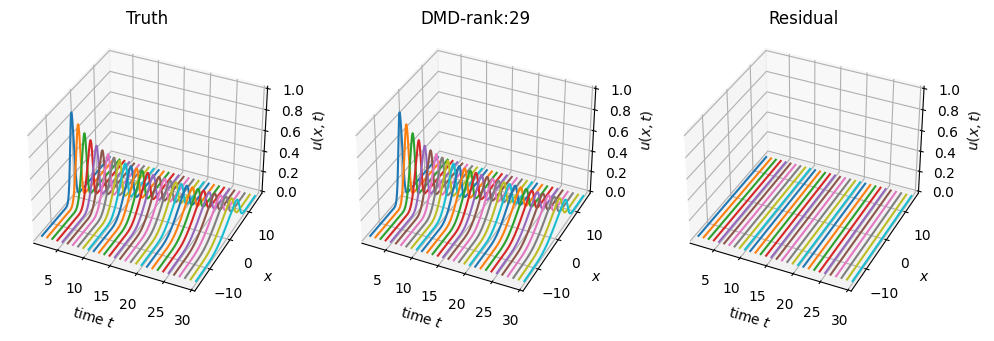

In [9]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0] - 1)))
plot_pde_dynamics(x,t,X, X_predicted, ['Truth','DMD-rank:'+str(model.A.shape[0]),'Residual'])